In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
df = pd.read_csv("features_df.csv")

In [2]:
numeric_features = ["title", "popularity", "energy", "liveness", "tempo", "speechiness", "acousticness", "instrumentalness", "time_signature", "danceability", "key", "loudness", "valence", "mode"]

In [3]:
df_f = df[numeric_features]
df_f.set_index("title", inplace=True)

In [4]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1750 entries, O Pana! to Strike (Holster)
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        1750 non-null   int64  
 1   energy            1750 non-null   float64
 2   liveness          1750 non-null   float64
 3   tempo             1750 non-null   float64
 4   speechiness       1750 non-null   float64
 5   acousticness      1750 non-null   float64
 6   instrumentalness  1750 non-null   float64
 7   time_signature    1750 non-null   int64  
 8   danceability      1750 non-null   float64
 9   key               1750 non-null   int64  
 10  loudness          1750 non-null   float64
 11  valence           1750 non-null   float64
 12  mode              1750 non-null   int64  
dtypes: float64(9), int64(4)
memory usage: 191.4+ KB


In [5]:
df_f.describe()

popularity       energy     liveness        tempo  speechiness  \
count  1750.000000  1750.000000  1750.000000  1750.000000  1750.000000   
mean     39.984000     0.599483     0.206333   123.797894     0.179418   
std      25.426781     0.180084     0.163178    28.933340     0.143432   
min       0.000000     0.022300     0.028000     0.000000     0.000000   
25%      19.000000     0.474250     0.106000   100.034250     0.055100   
50%      46.000000     0.599000     0.134000   127.017000     0.138000   
75%      60.000000     0.731000     0.252000   142.951250     0.277000   
max      97.000000     0.999000     0.980000   210.164000     0.915000   

       acousticness  instrumentalness  time_signature  danceability  \
count   1750.000000       1750.000000     1750.000000   1750.000000   
mean       0.241785          0.073885        3.954857      0.654890   
std        0.267291          0.208976        0.347690      0.161264   
min        0.000003          0.000000        0.000000      0.000000   
25%        0.027025          0.000000        4.000000      0.554000   
50%        0.125500          0.000006        4.000000      0.677000   
75%        0.376750          0.002260        4.000000      0.772000   
max        0.993000          0.960000        5.000000      0.985000   

               key     loudness      valence         mode  
count  1750.000000  1750.000000  1750.000000  1750.000000  
mean      5.195429    -8.215059     0.420078     0.617714  
std       3.740218     3.332309     0.231564     0.486085  
min       0.000000   -26.134000     0.000000     0.000000  
25%       1.000000    -9.917250     0.229000     0.000000  
50%       5.000000    -7.736500     0.401000     1.000000  
75%       9.000000    -5.971000     0.585500     1.000000  
max      11.000000     0.915000     0.982000     1.000000

In [6]:
df_f.drop(columns=["popularity", "liveness", "speechiness", "time_signature", "key", "mode"], inplace=True)

/var/folders/y_/d0wbwn_s1tlbh09zvpsn9bp40000gn/T/ipykernel_32472/3260913605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_f.drop(columns=["popularity", "liveness", "speechiness", "time_signature", "key", "mode"], inplace=True)


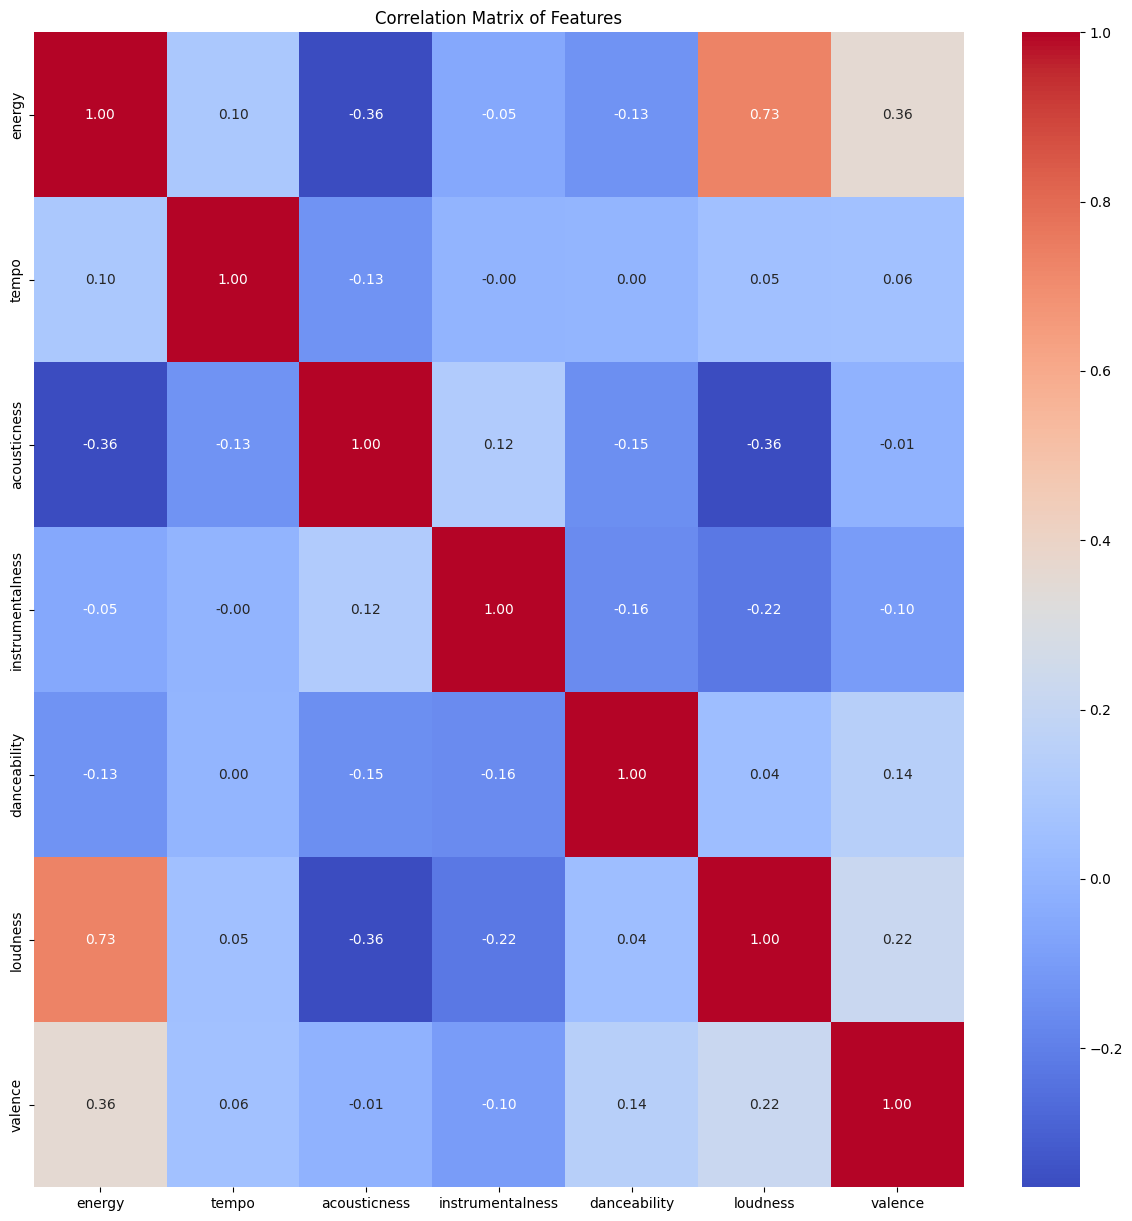

In [7]:
corr_matrix = df_f.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features")
plt.show()

# Remove highly correlated features
thresh_corr = 0.7
columns_to_remove = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > thresh_corr:
            colname = corr_matrix.columns[i]
            if colname not in columns_to_remove:
                columns_to_remove.append(colname)

data = df_f.drop(columns_to_remove, axis=1)

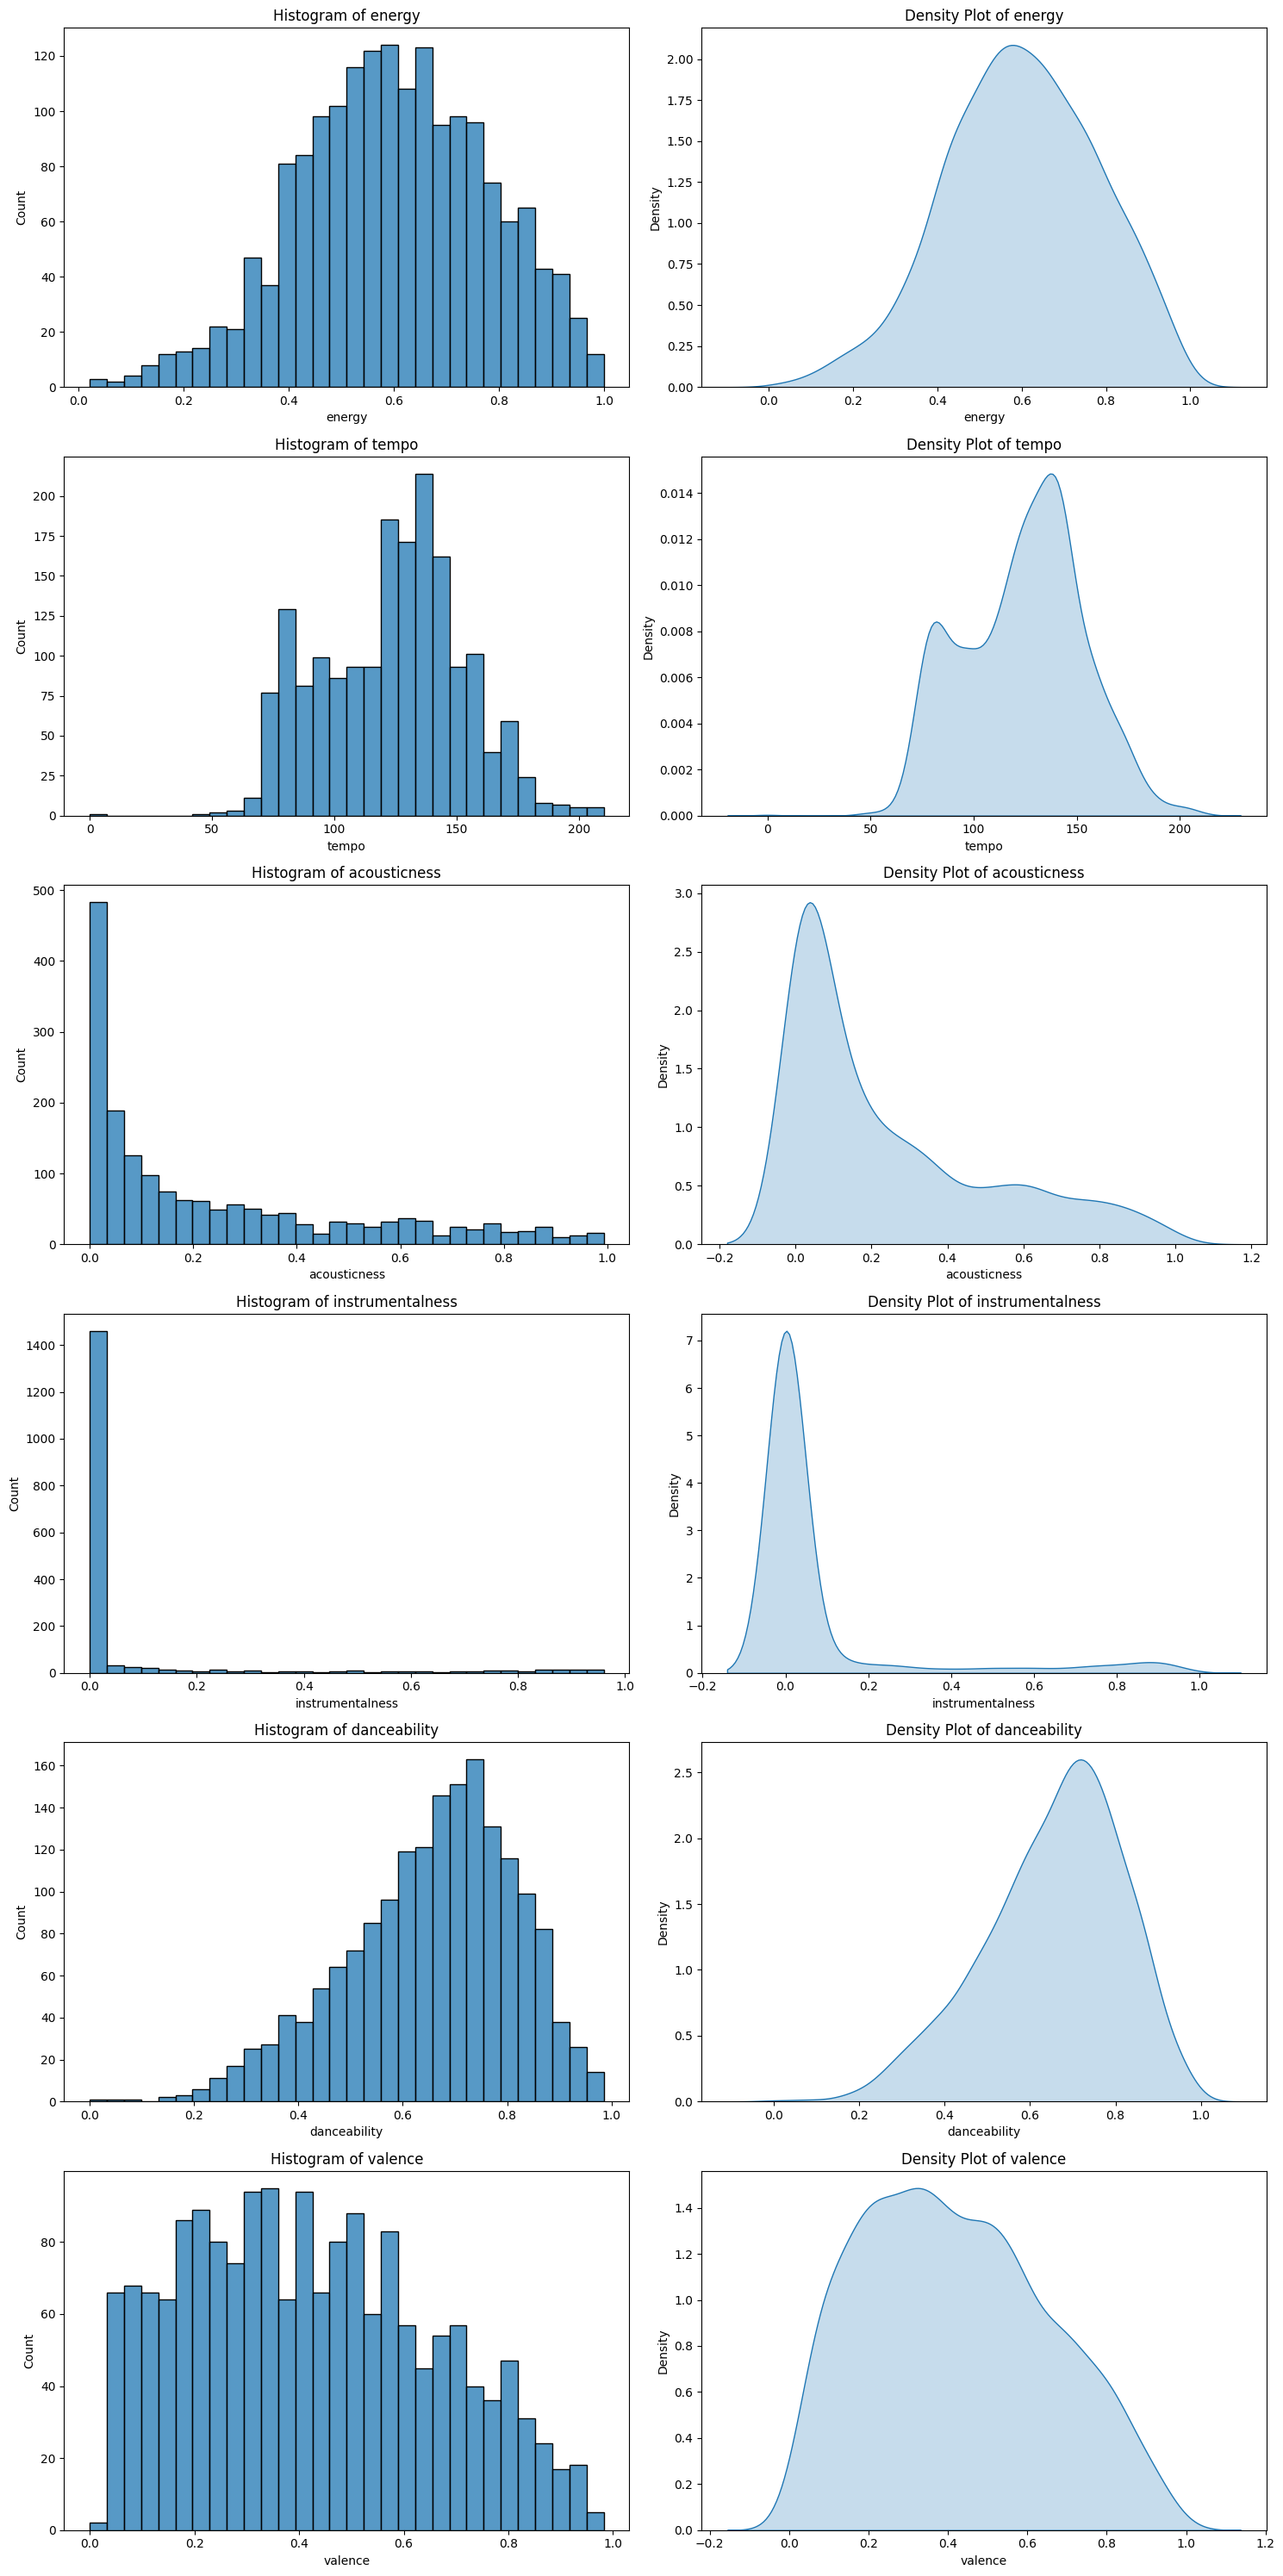

In [8]:
num_features = data.select_dtypes(include=[np.number]).columns
figure, axes = plt.subplots(len(num_features), 2, figsize=(15, 5 * len(num_features)))

i = 0
for feature in num_features:
    sns.histplot(data[feature], kde=False, ax=axes[i][0], bins=30)
    axes[i][0].set_title(f'Histogram of {feature}')
    sns.kdeplot(data[feature], fill=True, ax=axes[i][1])
    axes[i][1].set_title(f'Density Plot of {feature}')
    i += 1

plt.tight_layout()
plt.show()

In [9]:
print("Skewness Values: ")
print(data.skew())

Skewness Values: 
energy             -0.189202
tempo              -0.079355
acousticness        1.116217
instrumentalness    3.041488
danceability       -0.569501
valence             0.291514
dtype: float64


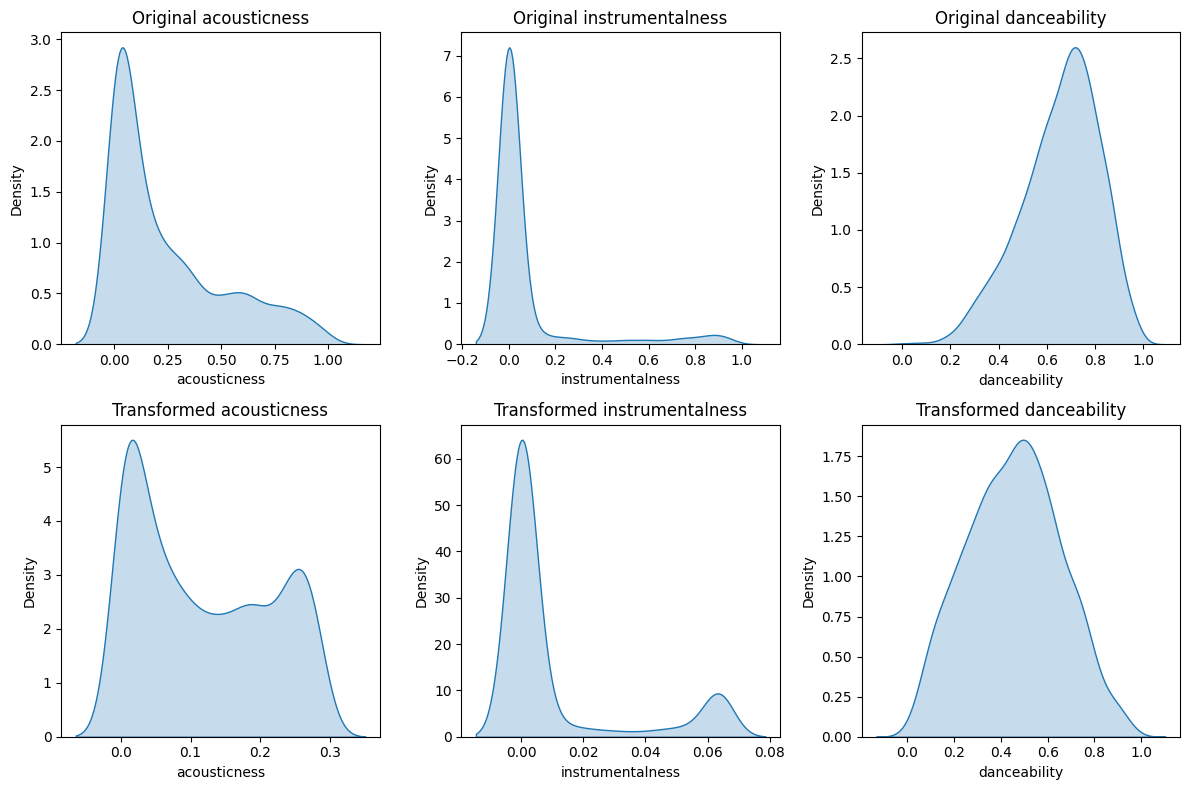

In [11]:
from scipy.stats import boxcox



# Copy the original data
data_original = data.copy()

# Apply transformations to right-skewed features
right_skewed_columns = ['acousticness', 'instrumentalness']
for col in right_skewed_columns:
    if data[col].nunique() > 1:
        data[col], _ = boxcox(data[col] + 1)

# Apply transformations to left-skewed features
left_skewed_columns = ['danceability']
for col in left_skewed_columns:
    if data[col].nunique() > 1:
        data[col] = np.square(data[col])

# Plot the original and transformed data side by side
columns_to_plot = right_skewed_columns + left_skewed_columns
n_cols = len(columns_to_plot)

fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(4 * n_cols, 8))

for i, col in enumerate(columns_to_plot):
    sns.kdeplot(data_original[col], ax=axes[0, i], fill=True)
    axes[0, i].set_title(f'Original {col}')
    sns.kdeplot(data[col], ax=axes[1, i], fill=True)
    axes[1, i].set_title(f'Transformed {col}')

plt.tight_layout()
plt.show()







In [12]:
print("Skewness Values: ")
print(data.skew())

Skewness Values: 
energy             -0.189202
tempo              -0.079355
acousticness        0.311325
instrumentalness    1.856363
danceability        0.046399
valence             0.291514
dtype: float64


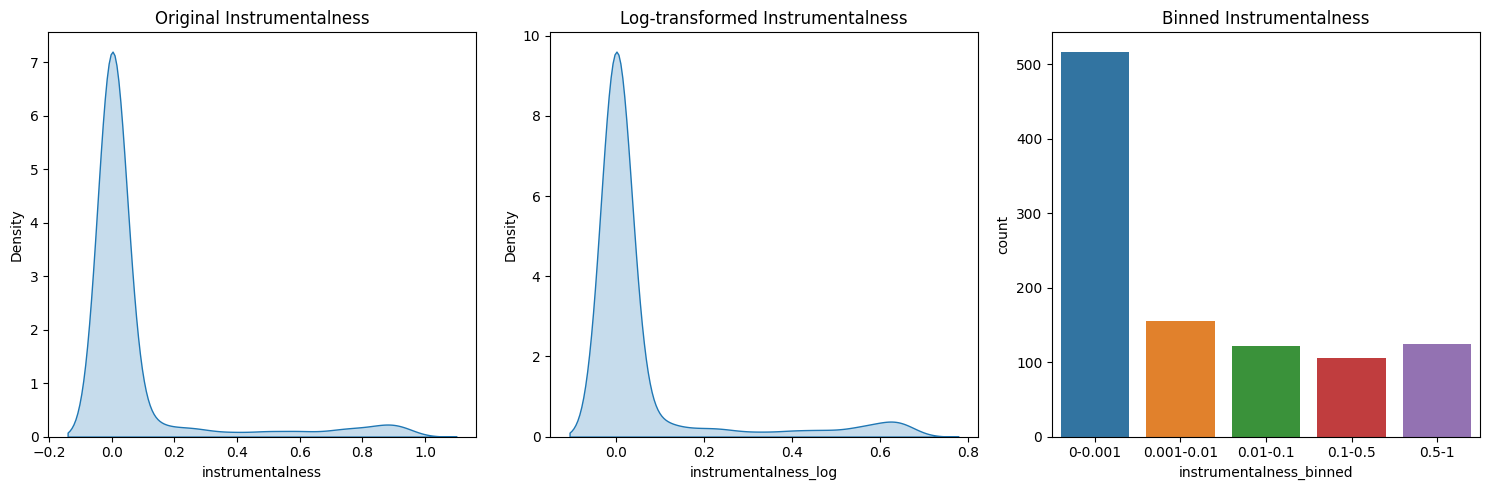

In [13]:
data = df_f.drop(columns_to_remove, axis=1)
data = data_original

data['instrumentalness_log'] = np.log1p(data['instrumentalness'])

# Create custom bins for instrumentalness
bins = [0, 0.001, 0.01, 0.1, 0.5, 1]
labels = ['0-0.001', '0.001-0.01', '0.01-0.1', '0.1-0.5', '0.5-1']
data['instrumentalness_binned'] = pd.cut(data['instrumentalness'], bins=bins, labels=labels)

# Plot the original, transformed, and binned data
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.kdeplot(data_original['instrumentalness'], ax=axes[0], fill=True)
axes[0].set_title('Original Instrumentalness')

sns.kdeplot(data['instrumentalness_log'], ax=axes[1], fill=True)
axes[1].set_title('Log-transformed Instrumentalness')

sns.countplot(data=data, x='instrumentalness_binned', ax=axes[2])
axes[2].set_title('Binned Instrumentalness')

plt.tight_layout()
plt.show()

/var/folders/y_/d0wbwn_s1tlbh09zvpsn9bp40000gn/T/ipykernel_32472/3738268952.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_original['instrumentalness'], ax=axes[0], shade=True)
/var/folders/y_/d0wbwn_s1tlbh09zvpsn9bp40000gn/T/ipykernel_32472/3738268952.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['instrumentalness_qt'], ax=axes[1], shade=True)


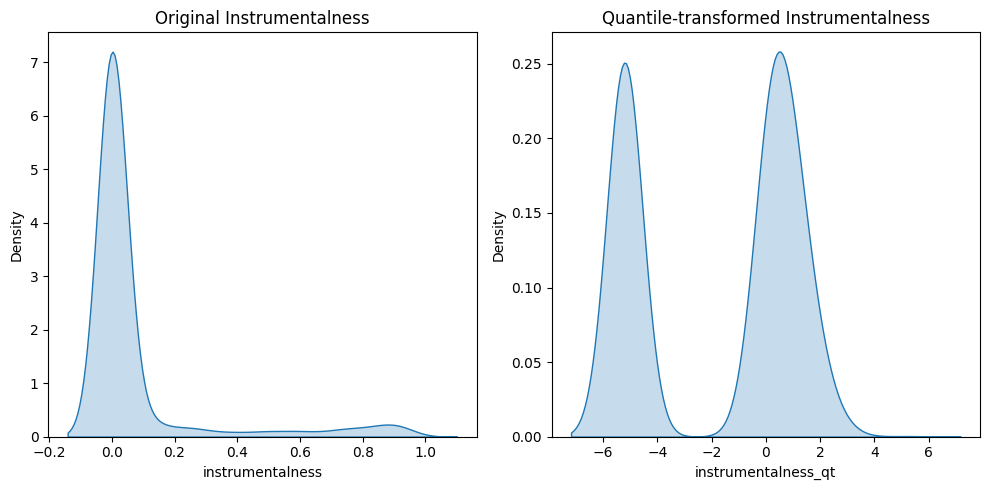

In [117]:
from sklearn.preprocessing import QuantileTransformer
data = df_f.drop(columns_to_remove, axis=1)
data = data_original

qt = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=42)
data['instrumentalness_qt'] = qt.fit_transform(data[['instrumentalness']])

# Plot the original and transformed data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.kdeplot(data_original['instrumentalness'], ax=axes[0], shade=True)
axes[0].set_title('Original Instrumentalness')

sns.kdeplot(data['instrumentalness_qt'], ax=axes[1], shade=True)
axes[1].set_title('Quantile-transformed Instrumentalness')

plt.tight_layout()
plt.show()

In [118]:
data = df_f.drop(columns_to_remove, axis=1)
qt = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=42)
data['instrumentalness'] = qt.fit_transform(data[['instrumentalness']])
right_skewed_columns = ['acousticness']
for col in right_skewed_columns:
    if data[col].nunique() > 1:
        data[col], _ = boxcox(data[col] + 1)

# Apply transformations to left-skewed features
left_skewed_columns = ['danceability']
for col in left_skewed_columns:
    if data[col].nunique() > 1:
        data[col] = np.square(data[col])
data.skew()

energy             -0.189202
tempo              -0.079355
acousticness        0.311325
instrumentalness    0.001502
danceability        0.046399
valence             0.291514
dtype: float64

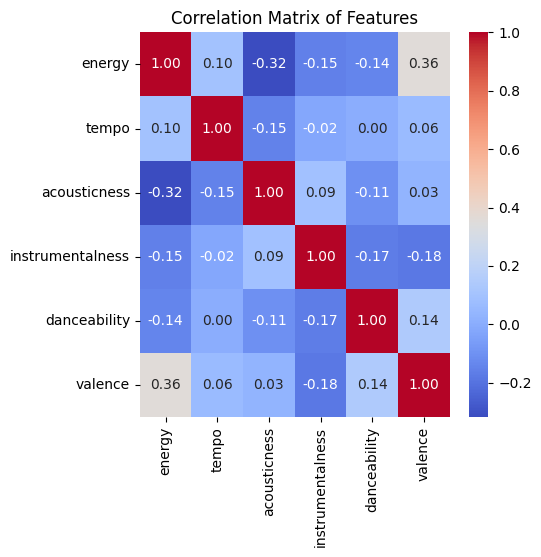

In [16]:
corr_matrix = data.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features")
plt.show()

In [17]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from umap.umap_ import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering

# Assuming your dataset is named `data`
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

Retained features: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535],
           dtype='int64', length=1536)


/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


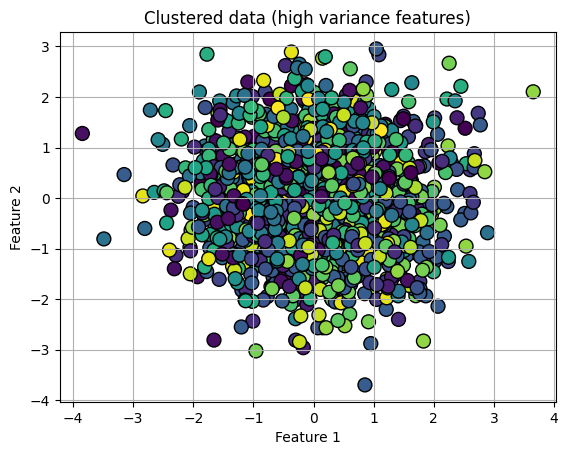

Retained features: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535],
           dtype='int64', length=1536)


/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


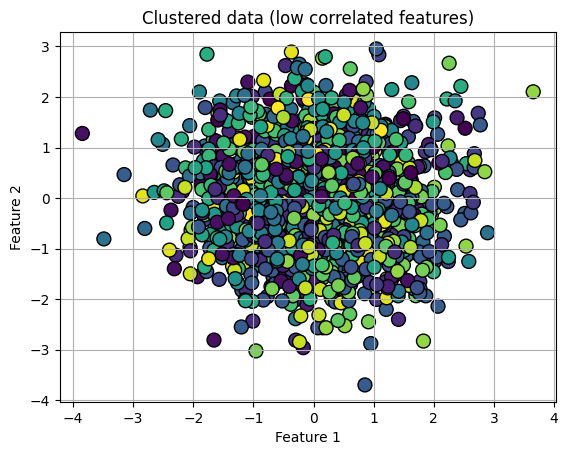

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


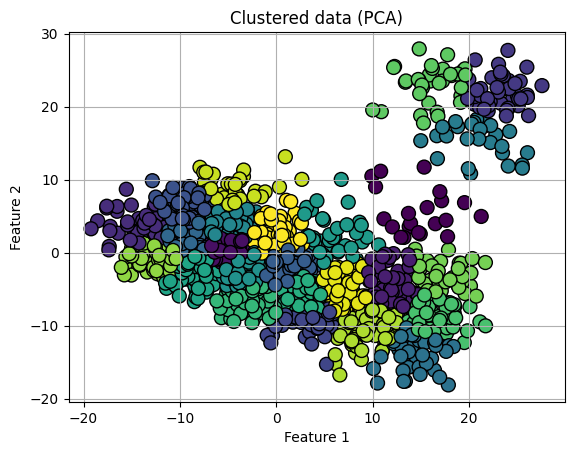

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


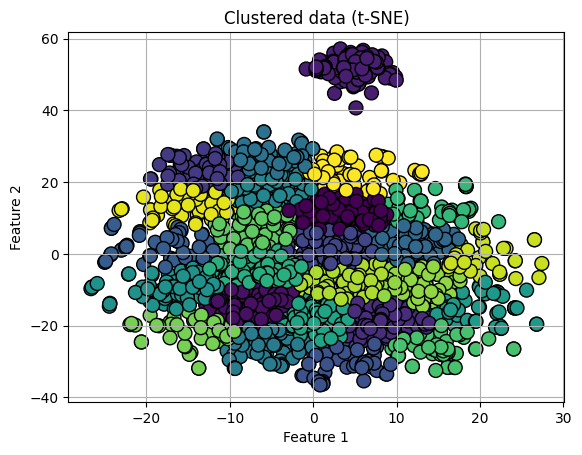

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/umap/spectral.py:227: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  warn(
/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


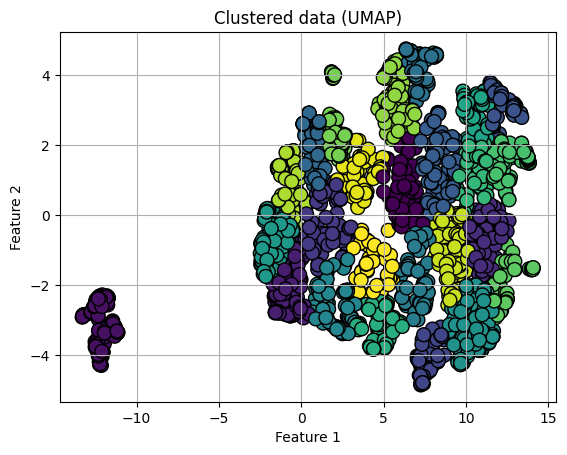

In [91]:
def plot_clustering(X, clusters, title):
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', edgecolor='k', s=100)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.grid()
    plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

# Step 3: Feature Selection - Variance Threshold
selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))  
X_high_variance = selector.fit_transform(X_scaled)
selected_features = selector.get_support()

print(f"Retained features: {df_embeddings.columns[selected_features]}")
kmeans = KMeans(n_clusters=25, random_state=42)
clusters_high_variance = kmeans.fit_predict(X_high_variance)
plot_clustering(X_high_variance, clusters_high_variance, 'Clustered data (high variance features)')

# Step 3B: Feature Selection - Highly Correlated Features
correlation_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
np.fill_diagonal(correlation_matrix, 0)
max_corr = correlation_matrix.max(axis=1)
mask = max_corr < 0.9  # Pick a threshold to decide which features to include

X_low_corr = X_scaled[:, mask]

print(f"Retained features: {df_embeddings.columns[mask]}")
clusters_low_corr = kmeans.fit_predict(X_low_corr)
plot_clustering(X_low_corr, clusters_low_corr, 'Clustered data (low correlated features)')

# Step 3C: Feature Selection - PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clusters_pca = kmeans.fit_predict(X_pca)
plot_clustering(X_pca, clusters_pca, 'Clustered data (PCA)')

# Step 3D: Feature Selection - t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
clusters_tsne = kmeans.fit_predict(X_tsne)
plot_clustering(X_tsne, clusters_tsne, 'Clustered data (t-SNE)')

reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_tsne)
clusters_UMAP = kmeans.fit_predict(X_umap)
plot_clustering(X_umap, clusters_UMAP, 'Clustered data (UMAP)')

In [92]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

datasets = [
    (X_high_variance, clusters_high_variance, "High Variance Features"),
    (X_low_corr, clusters_low_corr, "Low Correlated Features"),
    (X_pca, clusters_pca, "PCA"),
    (X_tsne, clusters_tsne, "t-SNE"),
    (X_umap, clusters_UMAP, "UMAP"),
]

print("Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique")
print("-------------------------------------------------------------------------")
for X_transformed, clusters, technique in datasets:
    silhouette = silhouette_score(X_transformed, clusters)
    davies_bouldin = davies_bouldin_score(X_transformed, clusters)
    calinski_harabasz = calinski_harabasz_score(X_transformed, clusters)
    print(f"{silhouette:.4f}          | {davies_bouldin:.4f}              | {calinski_harabasz:.4f}                | {technique}")

Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique
-------------------------------------------------------------------------
0.0048          | 5.4150              | 12.2213                | High Variance Features
0.0048          | 5.4150              | 12.2213                | Low Correlated Features
0.3286          | 0.8462              | 2203.3242                | PCA
0.3669          | 0.7931              | 2172.1615                | t-SNE
0.4280          | 0.7892              | 4416.5583                | UMAP


In [32]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFE, SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Load the Iris dataset
X = data
y = clusters_UMAP

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Filter Methods
# Pearson's Correlation Coefficient
corr_matrix = np.abs(np.corrcoef(X_scaled, y, rowvar=False)[:6, 6])
print("Pearson Correlation Coefficient:", corr_matrix)

# Chi-squared Test
chi2_selector = SelectKBest(chi2, k=2)
X_chi2 = chi2_selector.fit_transform(X, y)
print("Chi-squared Test selected features:", chi2_selector.get_support())

# Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=2)
X_mi = mi_selector.fit_transform(X_scaled, y)
print("Mutual Information selected features:", mi_selector.get_support())

# 2. Wrapper Methods
# Recursive Feature Elimination with Linear Regression estimator
lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=2)
X_rfe = rfe.fit_transform(X_scaled, y)
print("RFE with Linear Regression selected features:", rfe.get_support())

# 3. Embedded Methods
# LASSO Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y)
lasso_selector = SelectFromModel(lasso)
X_lasso = lasso_selector.fit_transform(X_scaled, y)
print("LASSO Regression selected features:", lasso_selector.get_support())

# Random Forests
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)
rf_selector = SelectFromModel(rf, max_features=2)
X_rf = rf_selector.fit_transform(X_scaled, y)
print("Random Forest selected features:", rf_selector.get_support())

# 4. Hybrid Methods
# Filter method followed by embedded method
# First, select high variance features (here we do not remove any)
thresh = .8 * (1 - .8)
variance_selector = VarianceThreshold(threshold=thresh)
X_high_variance = variance_selector.fit_transform(X_scaled)

# Then, perform feature selection using Random Forests on the remaining features
rf_hybrid = RandomForestClassifier(random_state=42)
rf_hybrid.fit(X_high_variance, y)
hybrid_selector = SelectFromModel(rf_hybrid, max_features=2)
X_hybrid = hybrid_selector.fit_transform(X_high_variance, y)
print("Hybrid Method selected features:", hybrid_selector.get_support())

Pearson Correlation Coefficient: [0.14150075 0.14748945 0.37754786 0.1214293  0.3340418  0.11191307]
Chi-squared Test selected features: [False  True False  True False False]
Mutual Information selected features: [False False  True  True False False]
RFE with Linear Regression selected features: [False False  True False  True False]
LASSO Regression selected features: [ True  True  True  True  True  True]
Random Forest selected features: [False  True  True False False False]
Hybrid Method selected features: [False  True  True False False False]


Retained features: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535],
           dtype='int64', length=1536)


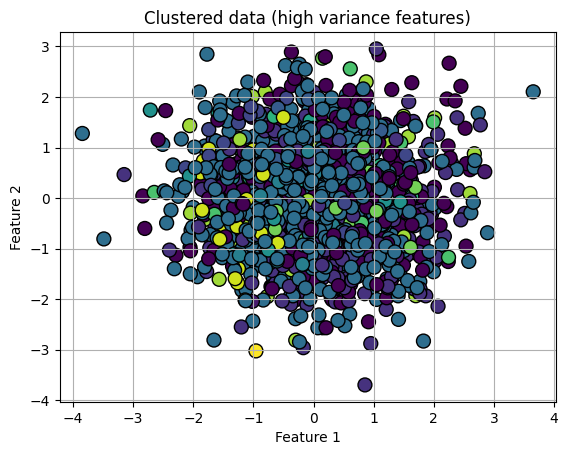

Retained features: Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535],
           dtype='int64', length=1536)


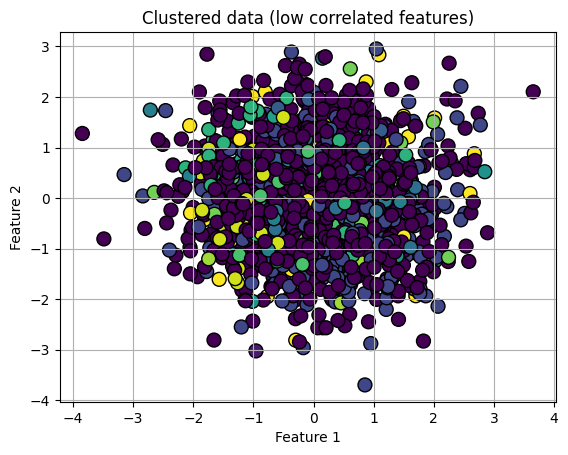

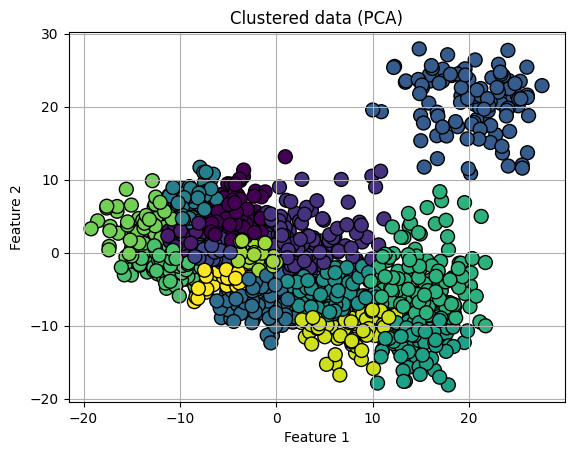

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


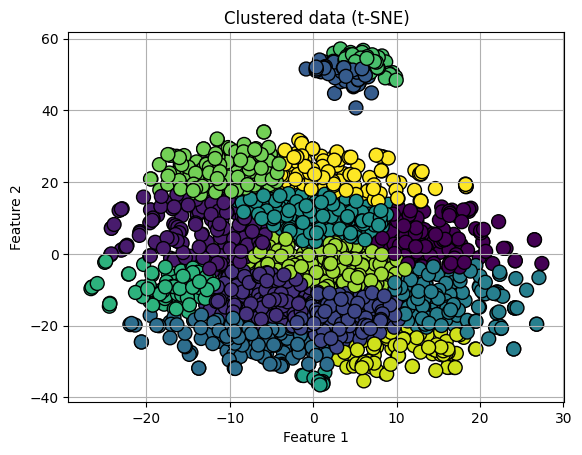

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


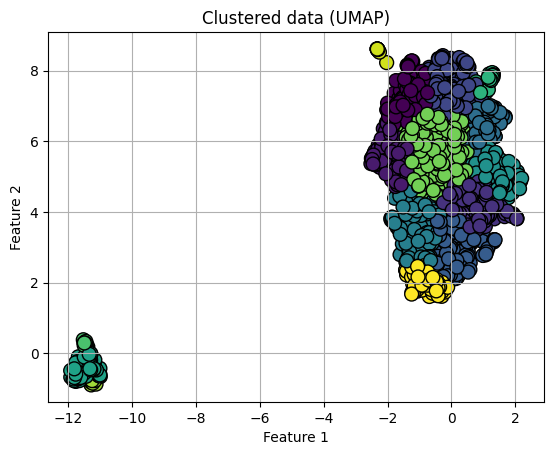

In [94]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import numpy as np


# Generate some sample data
# Step 3: Feature Selection - Variance Threshold

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_embeddings)


# Create spectral clustering object
n_clusters = 15  # set the number of clusters
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10)

# Fit and predict clusters

selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))  
X_high_variance = selector.fit_transform(X_scaled)
selected_features = selector.get_support()

print(f"Retained features: {df_embeddings.columns[selected_features]}")
kmeans = KMeans(n_clusters=25, random_state=42)
clusters_high_variance = spectral.fit_predict(X_high_variance)
plot_clustering(X_high_variance, clusters_high_variance, 'Clustered data (high variance features)')

# Step 3B: Feature Selection - Highly Correlated Features
correlation_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
np.fill_diagonal(correlation_matrix, 0)
max_corr = correlation_matrix.max(axis=1)
mask = max_corr < 0.9  # Pick a threshold to decide which features to include

X_low_corr = X_scaled[:, mask]

print(f"Retained features: {df_embeddings.columns[mask]}")
clusters_low_corr = spectral.fit_predict(X_low_corr)
plot_clustering(X_low_corr, clusters_low_corr, 'Clustered data (low correlated features)')

# Step 3C: Feature Selection - PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clusters_pca = spectral.fit_predict(X_pca)
plot_clustering(X_pca, clusters_pca, 'Clustered data (PCA)')

# Step 3D: Feature Selection - t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
clusters_tsne = spectral.fit_predict(X_tsne)
plot_clustering(X_tsne, clusters_tsne, 'Clustered data (t-SNE)')


reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
clusters_UMAP = spectral.fit_predict(X_umap)
plot_clustering(X_umap, clusters_UMAP, 'Clustered data (UMAP)')



In [95]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

datasets = [
    (X_high_variance, clusters_high_variance, "High Variance Features"),
    (X_low_corr, clusters_low_corr, "Low Correlated Features"),
    (X_pca, clusters_pca, "PCA"),
    (X_tsne, clusters_tsne, "t-SNE"),
    (X_umap, clusters_UMAP, "UMAP"),
]

print("Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique")
print("-------------------------------------------------------------------------")
for X_transformed, clusters, technique in datasets:
    silhouette = silhouette_score(X_transformed, clusters)
    davies_bouldin = davies_bouldin_score(X_transformed, clusters)
    calinski_harabasz = calinski_harabasz_score(X_transformed, clusters)
    print(f"{silhouette:.4f}          | {davies_bouldin:.4f}              | {calinski_harabasz:.4f}                | {technique}")

Silhouette Score | Davies-Bouldin Index | Calinski-Harabasz Index | Technique
-------------------------------------------------------------------------
0.0014          | 3.9786              | 15.1509                | High Variance Features
-0.0012          | 3.5093              | 14.3420                | Low Correlated Features
0.3161          | 0.8379              | 1914.9563                | PCA
0.3219          | 0.8714              | 1846.2296                | t-SNE
0.2963          | 0.7919              | 4225.8797                | UMAP


Retained features: Index(['energy', 'tempo', 'acousticness', 'instrumentalness', 'danceability',
       'valence'],
      dtype='object')


/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


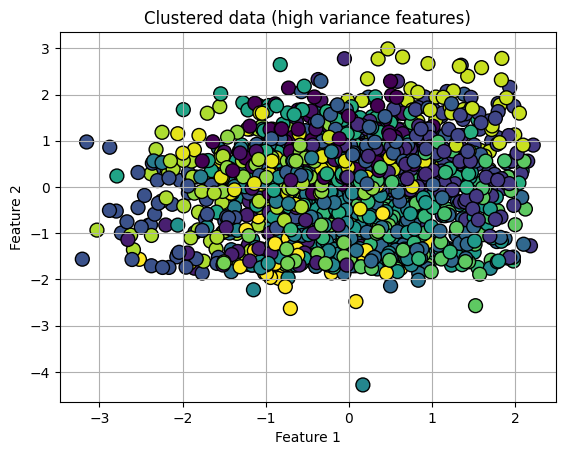

Retained features: Index(['energy', 'tempo', 'acousticness', 'instrumentalness', 'danceability',
       'valence'],
      dtype='object')


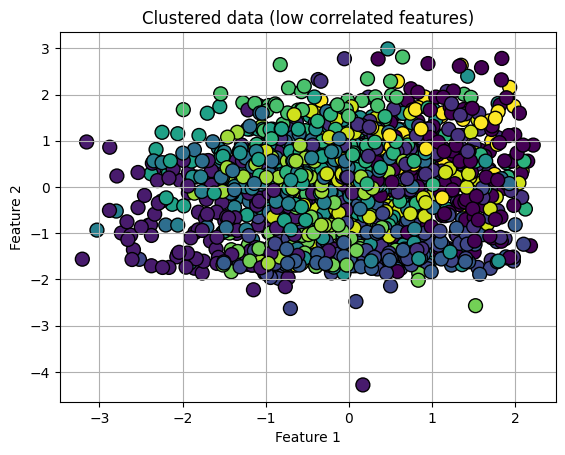

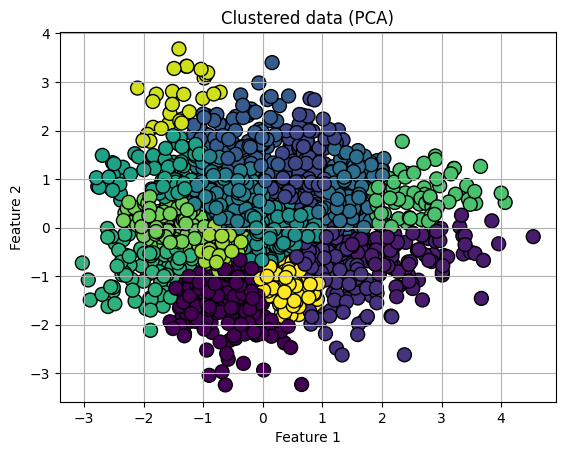

/Users/gavinmason/miniconda3/envs/botify/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


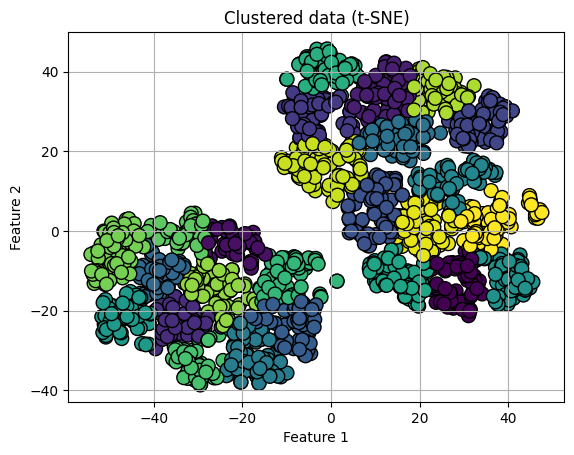

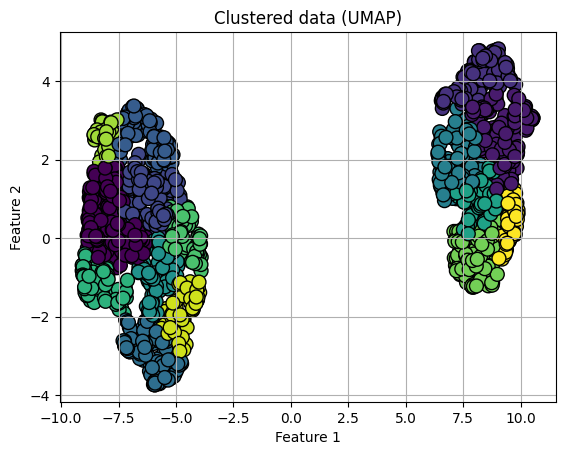

In [97]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering

# Step 3: Feature Selection - Variance Threshold
selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))  
X_high_variance = selector.fit_transform(X_scaled)
selected_features = selector.get_support()

print(f"Retained features: {data.columns[selected_features]}")
hierarchical = AgglomerativeClustering(n_clusters=15)
clusters_high_variance = kmeans.fit_predict(X_high_variance)
plot_clustering(X_high_variance, clusters_high_variance, 'Clustered data (high variance features)')

# Step 3B: Feature Selection - Highly Correlated Features
correlation_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
np.fill_diagonal(correlation_matrix, 0)
max_corr = correlation_matrix.max(axis=1)
mask = max_corr < 0.9  # Pick a threshold to decide which features to include

X_low_corr = X_scaled[:, mask]

print(f"Retained features: {data.columns[mask]}")
clusters_low_corr = hierarchical.fit_predict(X_low_corr)
plot_clustering(X_low_corr, clusters_low_corr, 'Clustered data (low correlated features)')

# Step 3C: Feature Selection - PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
clusters_pca = hierarchical.fit_predict(X_pca)
plot_clustering(X_pca, clusters_pca, 'Clustered data (PCA)')

# Step 3D: Feature Selection - t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
clusters_tsne = kmeans.fit_predict(X_tsne)
plot_clustering(X_tsne, clusters_tsne, 'Clustered data (t-SNE)')
df["clusters"] = clusters_tsne

reducer = UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)
clusters_UMAP = hierarchical.fit_predict(X_umap)
plot_clustering(X_umap, clusters_UMAP, 'Clustered data (UMAP)')

In [54]:
df = pd.read_csv("features_df.csv")
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Create a DataFrame with the numerical features

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize each feature separately
df['danceability_normalized'] = scaler.fit_transform(df[['danceability']])
df['energy_normalized'] = scaler.fit_transform(df[['energy']])
df['acousticness_normalized'] = scaler.fit_transform(df[['acousticness']])
df['instrumentalness_normalized'] = scaler.fit_transform(df[['instrumentalness']])
df['valence_normalized'] = scaler.fit_transform(df[['valence']])
df['tempo_normalized'] = scaler.fit_transform(df[['tempo']])

In [56]:
import random
def assign_danceability(value):
    not_suitable = [
        'Not suitable for dancing', 
        'Terrible for dancing', 
        'No dance vibes', 
        'Not engaging at all', 
        'Barely entertaining', 
        'Lacks energy and rhythm', 
        'Not recommended for fun activities'
    ]
    slightly_suitable = [
        'Slightly suitable for dancing', 
        'A hint of danceability', 
        'Could maybe dance to this', 
        'Mildly engaging', 
        'Somewhat entertaining', 
        'A touch of rhythm', 
        'Not bad for casual fun'
    ]
    suitable = [
        'Suitable for dancing', 
        'Danceable', 
        'Move to the groove', 
        'Engaging and entertaining', 
        'Good for a variety of activities', 
        'Catchy rhythm and beat', 
        'Fun for parties and gatherings'
    ]
    highly_suitable = [
        'Highly suitable for dancing', 
        'Perfect for dancing', 
        'Dance floor magnet', 
        'Extremely engaging', 
        'Highly entertaining', 
        'Ideal for various activities', 
        'A must-have for any party playlist'
    ]
    cant_stop_moving = [
        "Can't stop moving", 
        'Irresistible dance moves', 
        'Dance party essential', 
        'Incredibly captivating', 
        'Unbelievable entertainment', 
        'Perfect for any energetic activity', 
        'Impossible to sit still'
    ]
    if value <= 0.2:
        return random.choice(not_suitable)
    elif value <= 0.4:
        return random.choice(slightly_suitable)
    elif value <= 0.6:
        return random.choice(suitable)
    elif value <= 0.8:
        return random.choice(highly_suitable)
    else:
        return random.choice(cant_stop_moving)


def assign_energy(value):
    sloth_like = [
        'Sloth-like', 'Laid-back energy', 'Super relaxed', 'Lazy vibes', 'Couch potato mode',
        'Snail-paced', 'Doze-inducing', 'Mellow to the core', 'Zero rush'
    ]

    chill_vibes = [
        'Chill vibes', 'Easygoing energy', 'Cool and calm', 'Breezy presence', 'Stress-free spirit',
        'Unruffled demeanor', 'Go-with-the-flow', 'Languid essence', 'Serene and tranquil'
    ]

    average_energy = [
        'Average energy', 'Middle-of-the-road energy', 'Neither high nor low energy', 'Neutral tempo',
        'Steady pace', 'Balanced liveliness', 'Standard vitality', 'Routine dynamism', 'Moderate pep'
    ]

    energetic = [
        'Energetic', 'Full of life', 'Bouncing with energy', 'Active and animated', 'Vibrant spirit',
        'Sprightly enthusiasm', 'Brisk and lively', 'Fired up', 'Peppy and zippy'
    ]

    vitality_overload = [
        'Vitality overload', 'Explosive energy', 'Through the roof energy', 'Turbocharged zest',
        'Supersonic liveliness', 'Hyperactive buzz', 'Intense vigor', 'Frenetic enthusiasm', 'Unstoppable force'
    ]
    if value <= 0.2:
        return random.choice(sloth_like)
    elif value <= 0.4:
        return random.choice(chill_vibes)
    elif value <= 0.6:
        return random.choice(average_energy)
    elif value <= 0.8:
        return random.choice(energetic)
    else:
        return random.choice(vitality_overload)




def assign_acousticness(value):
    high_tech = ['High-tech', 'Synthetic sounds', 'Electronic vibes', 'Futuristic audio', 'Digitally-enhanced', 'Cutting-edge sonics', 'Modernized melodies', 'Innovative audio experiences', 'Robotic rhythms', 'Sci-fi soundscapes']

    electro_acoustic = ['Electro-acoustic', 'Hybrid sounds', 'Mix of natural and electronic', 'Fusion of acoustic and digital', 'Synergy of organic and synthetic', 'Crossover tones', 'Amalgamated audio', 'Blended soundscapes', 'Melded melodies', 'Technorganic tunes']

    balanced = ['Balanced', 'Combination of acoustic and electronic', 'Well-rounded sound', 'Equilibrium audio', 'Harmonious blend', 'Even mix of sound sources', 'In-sync audio', 'Stable soundscapes', 'Yin-yang of audio', 'Auditory harmony']

    acoustic = ['Acoustic', 'Natural sound', 'Unprocessed and organic', 'Authentic audio', 'Raw resonance', 'Original and unmodified', 'Pure and untouched', 'Straight-from-the-source', 'True-to-life tones', 'Untainted tunes']

    unplugged = ['Unplugged', 'Purely acoustic', 'Stripped-down and raw', 'Bare-bones audio', 'Unadorned acoustics', 'Simple and honest sound', 'Essence of the music', 'Back-to-basics', 'Intimate and close-up', 'Straight to the heart sounds']

    if value <= 0.2:
        return random.choice(high_tech)
    elif value <= 0.4:
        return random.choice(electro_acoustic)
    elif value <= 0.6:
        return random.choice(balanced)
    elif value <= 0.8:
        return random.choice(acoustic)
    else:
        return random.choice(unplugged)


def assign_instrumentalness(value):
    vocal_centric = ['Vocal-centric', 'Lyric-focused', 'All about the voice', 'Voice-driven', 'Singing takes the spotlight', 'Primarily vocal', 'Centered on vocals', 'Lyrics steal the show']

    vocal_instrumental_blend = ['Vocal-instrumental blend', 'Nice mix of vocals and instruments', 'Equal focus on voice and instruments', 'Harmonious vocal-instrumental balance', 'Perfect fusion of voice and instruments', 'Vocals and instruments in sync', 'Even emphasis on both vocals and instruments', 'Neck and neck with voice and instruments']

    instrumental_leaning = ['Instrumental-leaning', 'More instrumental than vocal', 'Instruments take center stage', 'Instruments lead the charge', 'Vocals play supporting role', 'Emphasis on the instrumentals', 'Instrument-heavy with a dash of vocals', 'Instruments in the limelight']

    instrumental_dominant = ['Instrumental dominant', 'Mostly instrumental', 'Vocals take a backseat', 'Instruments reign supreme', 'Vocals sparingly used', 'Majority of focus on instrumentals', 'Mainly about the instruments', 'Barely any vocals present']

    completely_instrumental = ['Completely instrumental', 'No vocals', 'Purely instrumental sounds', 'Devoid of vocals', 'Vocals-free', 'All-instrumental performance', 'Solely about instrumentals', 'Without a hint of vocalization']

    if value <= 0.2:
        return random.choice(vocal_centric)
    elif value <= 0.4:
        return random.choice(vocal_instrumental_blend)
    elif value <= 0.6:
        return random.choice(instrumental_leaning)
    elif value <= 0.8:
        return random.choice(instrumental_dominant)
    else:
        return random.choice(completely_instrumental)


def assign_valence(value):
    heartbroken = ['Heartbroken', 'Emotionally heavy', 'Tear-jerking', 'Crushed with sadness', 'Grief-stricken', 'Overwhelmed with sorrow', 'Drowning in pain']
    blue = ['Blue', 'Somber mood', 'Downcast', 'Melancholic', 'Slightly disheartened', 'Feeling under the weather', 'Little bit gloomy']
    neutral = ['Neutral', 'Neither happy nor sad', 'Emotionally balanced', 'Even-keeled', 'Mood equilibrium', 'Steady state of mind', 'Contentedly ambivalent']
    joyful = ['Joyful', 'Full of happiness', 'Uplifting and cheerful', 'Beaming with delight', 'Brimming with joy', 'Bubbling with happiness', 'Sunshine and smiles']
    ecstatic = ['Ecstatic', 'Euphoric', 'Over-the-top joy', 'Skyrocketing happiness', 'Elated beyond measure', 'Intoxicated with joy', 'Awe-inspired elation']

    if value <= 0.2:
        return random.choice(heartbroken)
    elif value <= 0.4:
        return random.choice(blue)
    elif value <= 0.6:
        return random.choice(neutral)
    elif value <= 0.8:
        return random.choice(joyful)
    else:
        return random.choice(ecstatic)


def assign_tempo(value):
    molasses_slow = ['Molasses slow', 'Crawling tempo', 'Leisurely pace', 'Glacial progress', 'Snail-like pace', 'Dawdling gait', 'Languid motion']
    slow = ['Slow', 'Unhurried', 'Relaxed tempo', 'Easygoing stride', 'Measured pace', 'Unruffled cadence', 'Laid-back rhythm']
    moderate = ['Moderate', 'Steady pace', 'Medium tempo', 'Balanced tempo', 'Composed gait', 'Even pace', 'Temperate rhythm']
    fast = ['Fast', 'Upbeat', 'Quick tempo', 'Brisk pace', 'Swift stride', 'Nimble rhythm', 'Energetic motion']
    lightning_fast = ['Lightning fast', 'Rapid-fire pace', 'Breakneck speed', 'Blistering quickness', 'Frenetic haste', 'Meteoric velocity', 'Turbulent acceleration']

    if value <= 0.2:
        return random.choice(molasses_slow)
    elif value <= 0.4:
        return random.choice(slow)
    elif value <= 0.6:
        return random.choice(moderate)
    elif value <= 0.8:
        return random.choice(fast)
    else:
        return random.choice(lightning_fast)
    
    
df['danceability_normalized'] = df['danceability_normalized'].apply(assign_danceability)
df['energy_normalized'] = df['energy_normalized'].apply(assign_energy)
df['acousticness_normalized'] = df['acousticness_normalized'].apply(assign_acousticness)
df['instrumentalness_normalized'] = df['instrumentalness_normalized'].apply(assign_instrumentalness)
df['valence_normalized'] = df['valence_normalized'].apply(assign_valence)
df['tempo_normalized'] = df['tempo_normalized'].apply(assign_tempo)

In [61]:
df_embed = df[["title", "lyrics", "danceability_normalized", "energy_normalized", "acousticness_normalized", "instrumentalness_normalized", "valence_normalized", "tempo_normalized", "genres"]]
df_embed.set_index("title", inplace=True)  
             
             
             
             
             
             

In [72]:
import concurrent.futures
import time
import pandas as pd
import openai
import tenacity
from typing import List, Dict, Tuple
from tqdm import tqdm

openai.api_key = ""
EMBEDDING_MODEL = "text-embedding-ada-002"


@tenacity.retry(reraise=True, stop=tenacity.stop_after_attempt(3), wait=tenacity.wait_fixed(5) + tenacity.wait_exponential(multiplier=2))
def get_embedding(text: str, model: str = EMBEDDING_MODEL, vector_length=1536):
    time.sleep(0.1)  # Wait for a tiny interval of time between each call
    result = openai.Embedding.create(
        model=model,
        input=text,
        output_format="list",
        vector_length=vector_length
    )
    return result["data"][0]["embedding"]

def get_embeddings_concurrently(texts: List[str]) -> List[List[float]]:
    embeddings = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_embedding = {executor.submit(get_embedding, text): text for text in texts}
        for future in tqdm(concurrent.futures.as_completed(future_to_embedding), total=len(texts)):
            try:
                embedding = future.result()
                embeddings.append(embedding)
            except Exception as e:
                print(f"Failed to obtain embedding: {e}")
                embeddings.append(None)
    return embeddings

df_embed["combined"] = df_embed.apply(''.join, axis=1)

embeddings = get_embeddings_concurrently(df_embed["combined"])




/var/folders/y_/d0wbwn_s1tlbh09zvpsn9bp40000gn/T/ipykernel_32472/2881370793.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_embed["combined"] = df_embed.apply(''.join, axis=1)
100%|███████████████████████████████████████| 1750/1750 [00:42<00:00, 41.20it/s]


In [79]:
df_embeddings = pd.DataFrame(embeddings)

In [80]:
df_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Columns: 1536 entries, 0 to 1535
dtypes: float64(1536)
memory usage: 20.5 MB


In [101]:
grouped = df.groupby("clusters")

In [116]:
grouped = df.groupby('clusters')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# create a list of dataframes for each cluster
dfs = []
for cluster_label, data in grouped:
    dfs.append(data)

# access the first dataframe for cluster 0
cluster_13_df = dfs[5]
cluster_13_df

title release_date  \
1                 Runnin' Thru The 7th With My Woadies   2015-09-01   
39                                  Benz Truck (гелик)   2017-08-15   
52                                                MILK   2017-06-09   
63                                           All I Got   2018-02-16   
75           Praise The Lord (Da Shine) (feat. Skepta)   2018-05-25   
106                               Time Will Get Us Too   2016-01-15   
125   I No Longer Fear The Razor Guarding My Heel (IV)   2018-09-07   
152                                     Hold My Liquor   2013-06-18   
177                                     Overdose > You   2018-08-30   
190                                   Gone (Interlude)   2018-02-02   
210                                              Pemex   2019-01-21   
221               Echoes in My Mind (feat. Wiccaphase)   2014-09-12   
236                                      Star Shopping         2015   
237                                 I Feel Like Chingy   2019-04-22   
281                                         Dark Light   2014-12-21   
313                                                BIG   2019-09-27   
318                                  Deira City Centre   2014-12-21   
321                           Welcome to the Hell Zone   2015-05-31   
323                            3AM (feat. ScHoolboy Q)   2019-07-19   
356                                       Blue Plastic   2019-11-07   
372                                         STRANDED *   2020-03-06   
384                                       Chain Smoker   2013-04-30   
471                                          Go Away!!   2019-10-25   
524                                              Alice   2013-06-08   
543            Stevie Wonder (Feat. Chance the Rapper)   2015-05-30   
592                                          Snake Ice   2020-12-21   
618                            90210 (feat. Kacy Hill)   2015-09-04   
635                                   Under the Bridge   1991-09-24   
657                                          APOLOGIZE   2019-07-19   
690                                          ghost boy   2019-11-15   
695                                           40 Acres   2018-10-05   
703                                           Michigan   2020-06-10   
725                                          Bloodhail   2008-01-01   
744                                         Guillotine   2011-08-03   
766                                            Tearful   2018-08-22   
783                                     Throw Dem Gunz   2012-02-11   
791                                          Sometimes   2018-05-07   
921                                            Forever   2017-01-18   
931               Loose Change (feat. Earl Sweatshirt)   2021-04-28   
938                                            Dresser   2018-12-31   
957              Back to the Old House - 2011 Remaster         1987   
1007                                         Blue Eyes   2019-11-27   
1008                                                JD   2015-05-26   
1024                                        SICK YOUTH   2016-04-27   
1031                                      Miami Ultras   2016-02-25   
1094                                        Old Friend   2022-01-14   
1117                                         vice city   2022-01-28   
1122                                           Crushed   1991-11-04   
1130                                        Thin Flesh   2018-05-18   
1137                                 Good Will Hunting   2022-02-04   
1166                              Murder she wrote ...   2021-11-06   
1183                   Punch Bowl (with Clipse & Nigo)   2022-03-25   
1213                                      All The Same   2022-04-22   
1214                                           Bitcoin   2018-05-12   
1218                                    Kirb in my cup   2022-04-25   
1241                                             On Go   2018-05-12   
12